In [ ]:
!pip install torchmetrics

In [2]:
import torch
import torchvision
import pandas as pd
import cv2
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
in_channels = 3
num_classes = 3
learning_rate = 1e-3
batch_size = 64
num_epochs = 5
load_model = False
save_model = False

In [ ]:
!rm -rf *
!pip install -U gdown
!gdown 1E1poQDBsRp53Ip9qndB2nPLu1po3AbEp
!gdown 18UXIh3mGA_M0oxlapPIrUG-VVpF6PN2S
!unzip Phase2.zip

In [10]:
class NoiseDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir='DataSet2', spreadsheet_file='Labels.xlsx', transform=None):
        self.label_mapping_dict = {'Gaussian': 0, 'Periodic': 1, 'Salt': 2}
        self.annotations = pd.read_excel(spreadsheet_file).drop(columns='Denoise Image')[['Noisy Image', 'Noise Type']]
        self.annotations['Noise Type'] = self.annotations['Noise Type'].map(self.label_mapping_dict)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(filename=img_path, flags=cv2.IMREAD_COLOR)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
        return (image, y_label)

dataset = NoiseDataset(transform=torchvision.transforms.ToTensor())
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [1000, 250])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = torchvision.models.efficientnet_v2_l(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.avgpool = torch.nn.Identity()
model.classifier[1] = torch.nn.Linear(in_features=327680, out_features=3, bias=True)
model.to(device)
model

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [13]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    print(f'Loss at epoch {epoch} was {loss}')

Loss at epoch 0 was 3.722674608230591
Loss at epoch 1 was 0.0
Loss at epoch 2 was 0.0
Loss at epoch 3 was 0.0
Loss at epoch 4 was 0.3441014587879181


In [14]:
from torchmetrics.functional.classification import multiclass_accuracy
from torchmetrics.functional.classification import multiclass_precision
from torchmetrics.functional.classification import multiclass_recall
from torchmetrics.functional.classification import multiclass_f1_score
from torchmetrics.functional.classification import multiclass_specificity
from torchmetrics.functional.classification import multiclass_auroc
from torchmetrics.functional.classification import multiclass_roc

def check_performance(loader, model):
    model.eval()
    full_y = torch.tensor([], device=device, dtype=torch.int8)
    full_predictions = torch.tensor([], device=device)
    full_scores = torch.tensor([], device=device)

    with torch.no_grad():
        for x, y in loader:

            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            predictions = scores.max(1)[1]
            full_y = torch.cat(tensors=(full_y, y))
            full_predictions = torch.cat(tensors=(full_predictions, predictions))
            full_scores = torch.cat(tensors=(full_scores, scores))

        accuracy = multiclass_accuracy(full_predictions, full_y, num_classes=3, average='macro')
        precision = multiclass_precision(full_predictions, full_y, num_classes=3, average='macro')
        recall = multiclass_recall(full_predictions, full_y, num_classes=3, average='macro')
        f1_score = multiclass_f1_score(full_predictions, full_y, num_classes=3, average='macro')
        specificity = multiclass_specificity(full_predictions, full_y, num_classes=3, average='macro')
        auroc = multiclass_auroc(full_scores, full_y, num_classes=3, average='macro')
        fpr, tpr, thresholds = multiclass_roc(full_scores, full_y, num_classes=3)
    model.train()
    return accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores

In [26]:
accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores = check_performance(train_loader, model)
print(f"Accuracy: {accuracy:.4}\nPrecision: {precision:.4}\nRecall: {recall:.4}\nF1 score: {f1_score:.4}\nSpecificity: {specificity:.4}\nArea under the ROC: {auroc:.4}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Specificity: 1.0
Area under the ROC: 1.0


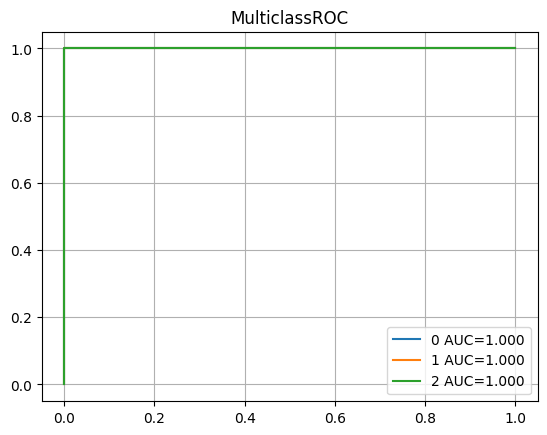

In [27]:
from torchmetrics.classification import MulticlassROC
metric = MulticlassROC(num_classes=3)
metric.update(full_scores, full_y)
fig_, ax_ = metric.plot(score=True)

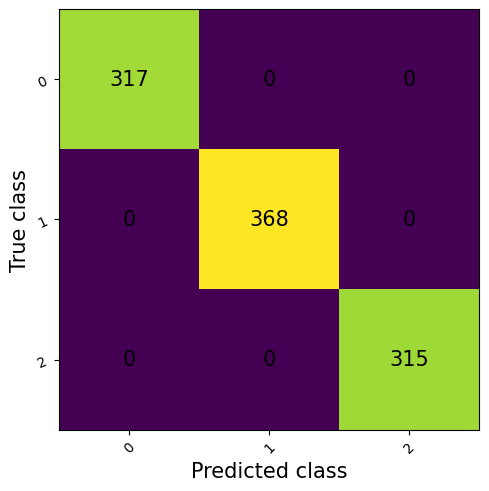

In [29]:
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=3).to(device)
metric.update(full_predictions, full_y)
fig_, ax_ = metric.plot()

In [30]:
accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores = check_performance(test_loader, model)
print(f"Accuracy: {accuracy:.4}\nPrecision: {precision:.4}\nRecall: {recall:.4}\nF1 score: {f1_score:.4}\nSpecificity: {specificity:.4}\nArea under the ROC: {auroc:.4}")

Accuracy: 0.9959
Precision: 0.996
Recall: 0.9959
F1 score: 0.996
Specificity: 0.998
Area under the ROC: 1.0


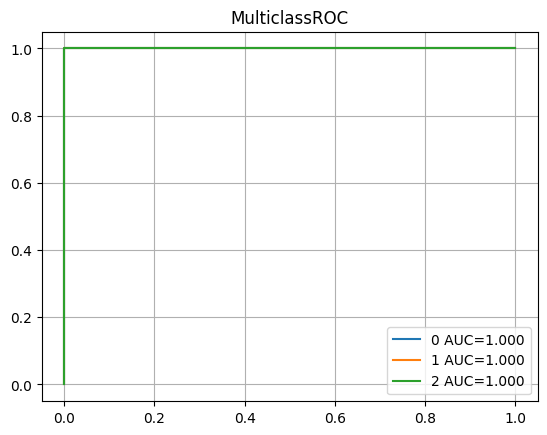

In [31]:
from torchmetrics.classification import MulticlassROC
metric = MulticlassROC(num_classes=3)
metric.update(full_scores, full_y)
fig_, ax_ = metric.plot(score=True)

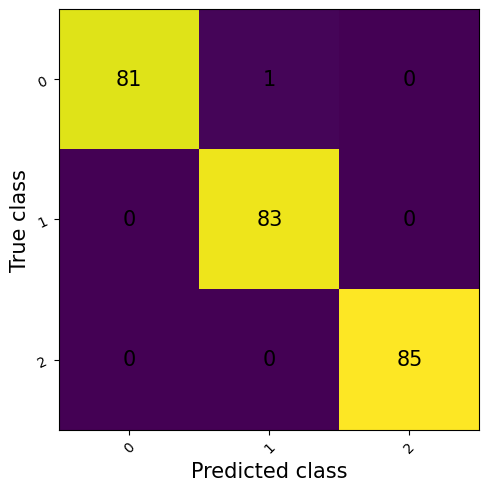

In [32]:
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=3).to(device)
metric.update(full_predictions, full_y)
fig_, ax_ = metric.plot()